In [1]:
import cv2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image

In [3]:
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa

In [4]:
from tqdm import tqdm

In [5]:
from sklearn.utils import class_weight, shuffle
import tensorflow as tf

In [6]:
import warnings
warnings.filterwarnings("ignore")
WINDOW_SIZE = 299
IMAGE_SIZE  = 512
IMAGE_CHANNELS=3
NUM_CLASSES=28

In [7]:
# Load dataset info
path_to_train = '../input/train/'
data = pd.read_csv('../input/train.csv')

train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

class data_generator:
    def __init__(self, it):
        self.it = it
    def __call__(self):
        return self.it

    def get_dataset(dataset_info, batch_size, shape, augument=True):
        gen = data_generator.create_train(dataset_info, batch_size, shape, augument)
        gen = data_generator(gen)
        types = (tf.float32, tf.float32)
        shapes=(tf.TensorShape((WINDOW_SIZE, WINDOW_SIZE, IMAGE_CHANNELS)), tf.TensorShape([NUM_CLASSES]))
        dataset = tf.data.Dataset.from_generator(
            gen, types, shapes
        )
        #dataset = dataset.repeat()
        dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(batch_size*8)
        return dataset

    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        dataset_info = shuffle(dataset_info)
        while True:
            for xs, xe, ys, ye in data_generator.slice_images():
                for idx in range(len(dataset_info)):
                    #X_train_batch = dataset_info[start:end]
                    batch_labels = np.zeros((NUM_CLASSES))
                    image = data_generator.load_image(
                            dataset_info[idx]['path'], shape)   
                    if augument:
                        image = data_generator.augment(image)
                    #print(image)
                    image=image/255.
                    #print(image)
                    batch_labels[dataset_info[idx]['labels']] = 1
                    yield image[xs:xe, ys:ye, :], batch_labels

    def load_image(path, shape):
        image_red_ch = Image.open(path+'_red.png')
        image_yellow_ch = Image.open(path+'_yellow.png')
        image_green_ch = Image.open(path+'_green.png')
        image_blue_ch = Image.open(path+'_blue.png')
        image = np.stack((
        np.array(image_red_ch), 
        np.array(image_green_ch), 
        np.array(image_blue_ch)), -1)
        #image = cv2.resize(image, (shape[0], shape[1]))
        return image

    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug

    def slice_images():
        offset = int(IMAGE_SIZE%WINDOW_SIZE)
        for i in range(2):
            for j in range(2):
                x_start=i*offset
                x_end=x_start+WINDOW_SIZE

                y_start=j*offset
                y_end=y_start+WINDOW_SIZE
                
                #print("x:{xs},{xe},{xd} y:{ys},{ye},{yd}".format(
                #    xs=x_start, xe=x_end, xd=x_end-x_start,
                #    ys=y_start, ye=y_end, yd=y_end-y_start
                #))

                #      batch,  x,                y,            channels
                #imgslice = image[x_start:x_end, y_start:y_end, :]
                #yield imagslice
                yield x_start, x_end, y_start, y_end
def iter_image_slices(image):
    for x_start, x_end, y_start, y_end in data_generator.slice_images():
        yield image[x_start:x_end, y_start:y_end, :]

In [8]:

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Reshape, Dense, Concatenate, GlobalMaxPooling2D
from keras.layers import BatchNormalization, Input, Conv2D, Lambda, Average
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam
from keras import backend as K
import keras
from keras.models import Model

    
def create_model(n_out):
    input_shape=(WINDOW_SIZE,WINDOW_SIZE, IMAGE_CHANNELS)
    input_tensor = Input(shape=(WINDOW_SIZE, WINDOW_SIZE, IMAGE_CHANNELS))
    base_model = InceptionV3(include_top=False,
                             weights='imagenet',
                             input_shape=input_shape
                             #input_shape=(WINDOW_SIZE, WINDOW_SIZE, IMAGE_CHANNELS)
                            )
    bn = BatchNormalization()(input_tensor)
    x = base_model(bn)
    x = Conv2D(32, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

# warm up model
model = create_model(n_out=NUM_CLASSES)

Using TensorFlow backend.


In [9]:
# create callbacks list
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

epochs = 10; batch_size = 16
checkpoint = ModelCheckpoint('../working/InceptionV3.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6)
callbacks_list = [checkpoint, early, reduceLROnPlat]

# split data into train, valid
indexes = np.arange(train_dataset_info.shape[0])
np.random.shuffle(indexes)
train_indexes, valid_indexes = train_test_split(indexes, test_size=0.15, random_state=8)

# create train and valid datagens
train_generator = data_generator.get_dataset(
    train_dataset_info[train_indexes], batch_size, (IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS), augument=True)
validation_generator = data_generator.get_dataset(
    train_dataset_info[valid_indexes], 32, (IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS), augument=False)


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 299, 299, 3)       12        
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 8, 8, 32)          65568     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
__________

2.2.4


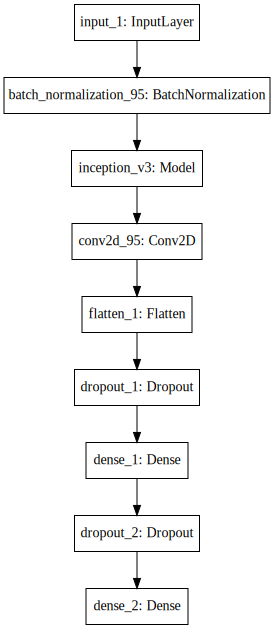

In [11]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
print(keras.__version__)
SVG(model_to_dot(model).create(prog='dot', format='svg'))


In [12]:


for layer in model.layers:
    layer.trainable = False
model.layers[-1].trainable = True
model.layers[-2].trainable = True
model.layers[-3].trainable = True
model.layers[-4].trainable = True
model.layers[-5].trainable = True
model.layers[-6].trainable = True

model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(1e-03),
    metrics=['acc'])
# model.summary()
train_images, train_labels = train_generator.make_one_shot_iterator().get_next()
val_images, val_labels = validation_generator.make_one_shot_iterator().get_next()
print(train_images, train_labels)
model.fit(
    x=train_images, y=train_labels,
    steps_per_epoch=int(np.ceil(float(len(train_indexes)) / float(batch_size))*4),
    validation_data=(val_images, val_labels),
    validation_steps=int(np.ceil(float(len(valid_indexes)) / float(batch_size))*4),
    epochs=2, 
    verbose=1)

Tensor("IteratorGetNext:0", shape=(16, 299, 299, 3), dtype=float32) Tensor("IteratorGetNext:1", shape=(16, 28), dtype=float32)
Train on 16 samples, validate on 32 samples
Epoch 1/2
6604/6604 [==============================] - 1594s 241ms/step - loss: 0.1735 - acc: 0.9418 - val_loss: 0.1811 - val_acc: 0.9408
Epoch 2/2
6604/6604 [==============================] - 1680s 254ms/step - loss: 0.1722 - acc: 0.9419 - val_loss: 0.1750 - val_acc: 0.9412


In [13]:
# train all layers
for layer in model.layers:
    layer.trainable = True
model.compile(loss='binary_crossentropy',
            optimizer=Adam(lr=1e-4),
            metrics=['accuracy'])
model.fit(
    x=train_images, y=train_labels,
    steps_per_epoch=int(np.ceil(float(len(train_indexes)) / float(batch_size))*4),
    validation_data=(val_images, val_labels),
    validation_steps=int(np.ceil(float(len(valid_indexes)) / float(batch_size))*4),
    epochs=epochs,
    verbose=1,
    callbacks=callbacks_list)

Train on 16 samples, validate on 32 samples
Epoch 1/3
6604/6604 [==============================] - 4724s 715ms/step - loss: 0.1481 - acc: 0.9507 - val_loss: 0.1273 - val_acc: 0.9571

Epoch 00001: val_loss improved from inf to 0.12726, saving model to ../working/InceptionV3.h5
Epoch 2/3
6604/6604 [==============================] - 4568s 692ms/step - loss: 0.1222 - acc: 0.9587 - val_loss: 0.1176 - val_acc: 0.9600

Epoch 00002: val_loss improved from 0.12726 to 0.11756, saving model to ../working/InceptionV3.h5
Epoch 3/3
6604/6604 [==============================] - 4374s 662ms/step - loss: 0.1102 - acc: 0.9625 - val_loss: 0.1059 - val_acc: 0.9638

Epoch 00003: val_loss improved from 0.11756 to 0.10587, saving model to ../working/InceptionV3.h5


In [17]:
# Create submit
submit = pd.read_csv('../input/sample_submission.csv')
predicted = []
draw_predict = []
model.load_weights('../working/InceptionV3.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('../input/test/', name)
    image = data_generator.load_image(path, (IMAGE_SIZE,IMAGE_SIZE,3))/255.
    classes=set()
    for s in iter_image_slices(image):
        score_predict = model.predict(s[np.newaxis])[0]
        draw_predict.append(score_predict)
        label_predict = np.arange(NUM_CLASSES)[score_predict>=0.2]
        classes.update(label_predict)
    str_predict_label = ' '.join(str(l) for l in classes)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('../output/draw_predict_InceptionV3.npy', score_predict)
submit.to_csv('../output/submit_InceptionV3.csv', index=False)

100%|██████████| 11702/11702 [19:48<00:00,  9.84it/s]
